In [23]:
import os
import pandas as pd

data = pd.read_csv('DNNProject/dataset/Data_Entry_2017.csv')
data = data.rename(columns={'Finding Label': 'Finding Labels'})
'''multiple_labels_count = data['Finding Labels'].str.contains(r'\|').sum()
print(f"Number of images with multiple labels: {multiple_labels_count}")
filtered = data[~data['Finding Labels'].str.contains(r'\|', na=False)]



print(filtered['Finding Labels'].value_counts())

data['Finding Labels'] = data['Finding Labels'].str.split('|')
exploded_data = data.explode('Finding Labels')

# Fjern eventuelle ledende eller etterfølgende mellomrom (kan være nyttig for å sikre riktige etikettnavn)
exploded_data['Finding Labels'] = exploded_data['Finding Labels'].str.strip()

# Tell forekomsten av hver unike etikett
label_counts = exploded_data['Finding Labels'].value_counts()

# Skriv ut resultatet
print("Fordeling av etiketter inkludert multi-label tilfeller:")
print(label_counts)'''

'multiple_labels_count = data[\'Finding Labels\'].str.contains(r\'\\|\').sum()\nprint(f"Number of images with multiple labels: {multiple_labels_count}")\nfiltered = data[~data[\'Finding Labels\'].str.contains(r\'\\|\', na=False)]\n\n\n\nprint(filtered[\'Finding Labels\'].value_counts())\n\ndata[\'Finding Labels\'] = data[\'Finding Labels\'].str.split(\'|\')\nexploded_data = data.explode(\'Finding Labels\')\n\n# Fjern eventuelle ledende eller etterfølgende mellomrom (kan være nyttig for å sikre riktige etikettnavn)\nexploded_data[\'Finding Labels\'] = exploded_data[\'Finding Labels\'].str.strip()\n\n# Tell forekomsten av hver unike etikett\nlabel_counts = exploded_data[\'Finding Labels\'].value_counts()\n\n# Skriv ut resultatet\nprint("Fordeling av etiketter inkludert multi-label tilfeller:")\nprint(label_counts)'

In [24]:
def filterData(data):
    filtered_data = data[
    ~data['Finding Labels'].str.contains('Hernia', na=False) &
    ~data['Finding Labels'].str.contains('Pneumonia', na=False) &
    ~data['Finding Labels'].str.contains('Edema', na=False) &
    ~data['Finding Labels'].str.contains('Cardiomegaly', na=False) &
    ~data['Finding Labels'].str.contains('Consolidation', na=False) &
    ~data['Finding Labels'].str.contains('Pleural_Thickening', na=False) &
    ~data['Finding Labels'].str.contains('Fibrosis', na=False) &
    ~data['Finding Labels'].str.contains('Emphysema', na=False) &
    #~data['Finding Labels'].str.contains('Nodule', na=False) &
    ~data['Finding Labels'].str.contains('Pneumothorax', na=False) &
    ~data['Finding Labels'].str.contains('Mass', na=False) &
    ~data['Finding Labels'].str.contains('No Finding', na=False) &
    ~data['Finding Labels'].str.contains(r'\|', na=False)
    ]
    return filtered_data
'''def singleLabel(data):
    return data[~data['Finding Labels'].str.contains(r'\|', na=False)]'''

"def singleLabel(data):\n    return data[~data['Finding Labels'].str.contains(r'\\|', na=False)]"

In [25]:
filtered_data = filterData(data)
filtered_data = filtered_data[['Image Index', 'Finding Labels']]

#secondFilterData = singleLabel(data)


In [26]:
def find_image_path_nested(image_index, base_dir):
    #global subfolders_with_valid_paths, subfolders_without_valid_paths
    subfolders = sorted(os.listdir(base_dir))  # Sort subfolders for consistency
    found_path = None  # Initialize as None

    for subfolder in subfolders:
        subfolder_path = os.path.join(base_dir, subfolder)
        if os.path.isdir(subfolder_path):  # Check if it's a directory
            # Look for a nested 'images' folder
            nested_images_path = os.path.join(subfolder_path, 'images')
            if os.path.exists(nested_images_path) and os.path.isdir(nested_images_path):
                # Check if the image exists in the nested folder
                image_path = os.path.join(nested_images_path, image_index)
                if os.path.exists(image_path):
                    #subfolders_with_valid_paths.add(subfolder)  # Mark subfolder as valid
                    found_path = image_path
                    break  # Stop searching once the image is found
            #else:
                #subfolders_without_valid_paths.add(subfolder)  # Mark as invalid
    return found_path

In [27]:
base_dir = 'DNNProject/dataset'

subfolders_with_valid_paths = set()
subfolders_without_valid_paths = set()

filtered_data['Image Path'] = filtered_data['Image Index'].apply(lambda x: find_image_path_nested(x, base_dir))


print(f"Number of None paths: {filtered_data['Image Path'].isna().sum()}")
print(f"Number of valid paths: {filtered_data['Image Path'].notna().sum()}")


filtered_data = filtered_data.dropna(subset=['Image Path'])


print(filtered_data.head())


Number of None paths: 0
Number of valid paths: 20422
         Image Index Finding Labels  \
19  00000005_006.png   Infiltration   
25  00000008_002.png         Nodule   
27  00000010_000.png   Infiltration   
28  00000011_000.png       Effusion   
33  00000011_005.png   Infiltration   

                                           Image Path  
19  DNNProject/dataset/images_001/images/00000005_...  
25  DNNProject/dataset/images_001/images/00000008_...  
27  DNNProject/dataset/images_001/images/00000010_...  
28  DNNProject/dataset/images_001/images/00000011_...  
33  DNNProject/dataset/images_001/images/00000011_...  


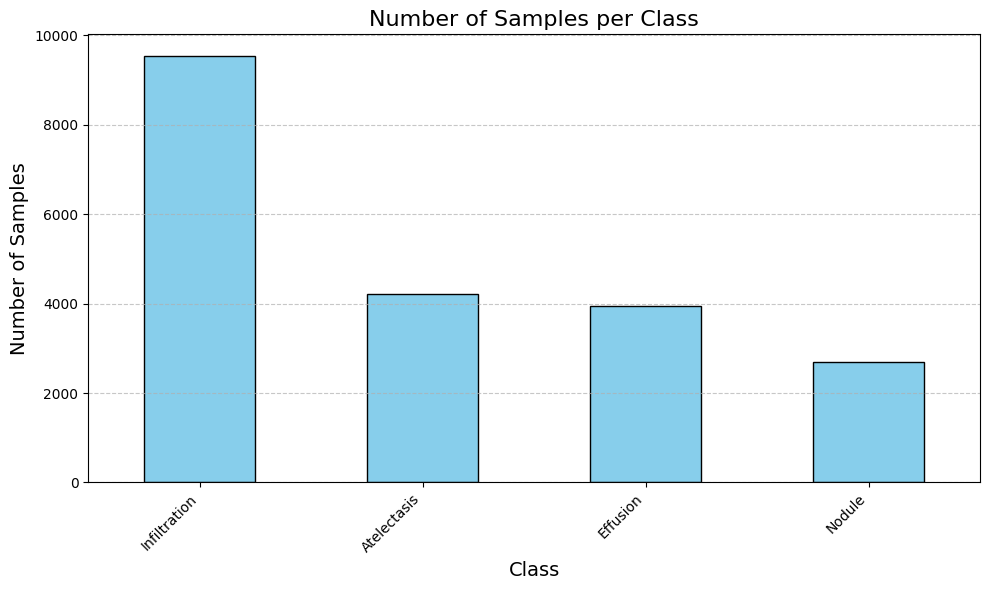

In [28]:
import matplotlib.pyplot as plt
from PIL import Image


class_counts = filtered_data['Finding Labels'].value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Samples per Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig('results/class_dist.png', dpi=300)
plt.show()

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

train_df, valid_df = train_test_split(
    filtered_data,
    test_size=0.20, 
    random_state=42,
    stratify=filtered_data['Finding Labels'] 
)

print("Training set distribution:")
print(train_df['Finding Labels'].value_counts())
print("\nValidation set distribution:")
print(valid_df['Finding Labels'].value_counts())


label_to_index = {label: idx for idx, label in enumerate(filtered_data['Finding Labels'].unique())}
index_to_label = {idx: label for label, idx in label_to_index.items()}  # Reverse mapping

train_df['Finding Labels'] = train_df['Finding Labels'].map(label_to_index)
valid_df['Finding Labels'] = valid_df['Finding Labels'].map(label_to_index)

print("\nLabel to Index Mapping:")
for label, idx in label_to_index.items():
    print(f"Label: {label}, Index: {idx}")


Training set distribution:
Infiltration    7637
Atelectasis     3372
Effusion        3164
Nodule          2164
Name: Finding Labels, dtype: int64

Validation set distribution:
Infiltration    1910
Atelectasis      843
Effusion         791
Nodule           541
Name: Finding Labels, dtype: int64

Label to Index Mapping:
Label: Infiltration, Index: 0
Label: Nodule, Index: 1
Label: Effusion, Index: 2
Label: Atelectasis, Index: 3


In [30]:
def resample_data(train_df, label_name,label_to_index, 
                  downsample=True, upsample=True, 
                  target_downsample_count=500, target_upsample_count=160):
   
    
    no_finding_label = label_to_index[label_name]
    no_finding_samples = train_df[train_df['Finding Labels'] == no_finding_label]
    other_classes = train_df[train_df['Finding Labels'] != no_finding_label]

  
    if downsample:
        print(f"Downsampling {label_name} to {target_downsample_count} samples.")
        downsampled_no_finding = no_finding_samples.sample(
            n=target_downsample_count, random_state=42
        )
    else:
        downsampled_no_finding = no_finding_samples

  
    upsampled_dfs = []
    if upsample:
        class_counts = other_classes['Finding Labels'].value_counts()
        classes_to_upsample = class_counts[class_counts < target_upsample_count].index
        print(f"Upsampling classes: {classes_to_upsample} to {target_upsample_count} samples each.")

        for class_label in classes_to_upsample:
            class_rows = other_classes[other_classes['Finding Labels'] == class_label]
            upsampled_rows = class_rows.sample(
                n=target_upsample_count, replace=True, random_state=42
            )
            upsampled_dfs.append(upsampled_rows)

   
    remaining_classes = other_classes[~other_classes['Finding Labels'].isin(classes_to_upsample)] if upsample else other_classes
    final_train_df = pd.concat([downsampled_no_finding, remaining_classes] + upsampled_dfs)

   
    final_train_df = final_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print("Resampling completed.")
    return final_train_df

"""train_df = resample_data(
    train_df=train_df,
    label_name = 'Infiltration',
    label_to_index=label_to_index,
    downsample=True,
    upsample=False,  # Disable upsampling
    target_downsample_count=300
)"""

train_df = resample_data(
    train_df=train_df,
    label_name = 'Infiltration',
    label_to_index=label_to_index,
    downsample=True,
    upsample=False,  # Disable upsampling
    target_downsample_count=4000
)

class_counts_after_sampling = train_df['Finding Labels'].value_counts()

print("Label | Index | Number of Samples")
print("-" * 40)
for label, idx in label_to_index.items():
    count = class_counts_after_sampling[idx] if idx in class_counts_after_sampling else 0
    print(f"{label:<15} | {idx:<5} | {count:<10}")


Downsampling Infiltration to 4000 samples.
Resampling completed.
Label | Index | Number of Samples
----------------------------------------
Infiltration    | 0     | 4000      
Nodule          | 1     | 2164      
Effusion        | 2     | 3164      
Atelectasis     | 3     | 3372      


In [31]:
from PIL import Image
import torch
from torch.utils.data import Dataset
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
    
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        img_path = self.dataframe.iloc[idx]['Image Path']
        label = self.dataframe.iloc[idx]['Finding Labels']

    
        image = Image.open(img_path).convert("RGB")  

        if self.transform:
            image = self.transform(image)

        label_tensor = torch.tensor(label, dtype=torch.long)

        return image, label_tensor

In [32]:
from torch.utils.data import DataLoader
from torchvision import transforms

#
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(train_transforms.transforms)


train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(valid_df, transform=val_transforms)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)



[Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True), RandomHorizontalFlip(p=0.5), RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]


In [33]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class ResBlocks(nn.Module):
    def __init__(self, in_channels, out_channels, use_bottleneck=False, downsample=False):
        super(ResBlocks, self).__init__()
        stride = 2 if downsample else 1

        if use_bottleneck:
            self.block = self.bottleneck_block(in_channels, out_channels, stride)
        else:
            self.block = self.residual_block(in_channels, out_channels, stride)

        # Oppdater shortcut for å bruke riktig stride hvis det er downsample
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def residual_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def bottleneck_block(self, in_channels, out_channels, stride):
        bottleneck_channels = out_channels // 4
        return nn.Sequential(
            nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.block(x) + self.shortcut(x))


In [34]:
class ResNet(nn.Module):
    def __init__(self, num_classes, resnetModel='ResNet50'):
        super(ResNet, self).__init__()
        self.resnetModel = resnetModel
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.num_classes = num_classes

        if resnetModel == 'ResNet34':
            self.res34layers()
        elif resnetModel == 'ResNet50':
            self.res50layers()
        else:
            print('Model not implemented')

        
    def res34layers(self):
        self.conv2_x = self._make_layer(64, 64, n_blocks=3, use_bottleneck=False)
        self.conv3_x = self._make_layer(64, 128, n_blocks=4, use_bottleneck=False, downsample=True)
        self.conv4_x = self._make_layer(128, 256, n_blocks=6, use_bottleneck=False, downsample=True)
        self.conv5_x = self._make_layer(256, 512, n_blocks=3, use_bottleneck=False, downsample=True)

        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(512, self.num_classes)
    def res50layers(self):
        self.conv2_x = self._make_layer(64, 256, n_blocks=3, use_bottleneck=True)
        self.conv3_x = self._make_layer(256, 512, n_blocks=4, use_bottleneck=True, downsample=True)
        self.conv4_x = self._make_layer(512, 1024, n_blocks=6, use_bottleneck=True, downsample=True)
        self.conv5_x = self._make_layer(1024, 2048, n_blocks=3, use_bottleneck=True, downsample=True)
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2048, self.num_classes)

    def _make_layer(self, in_channels, out_channels, n_blocks, use_bottleneck, downsample=False):
        layers = [ResBlocks(in_channels, out_channels, use_bottleneck, downsample)]
        for _ in range(1, n_blocks):
            layers.append(ResBlocks(out_channels, out_channels, use_bottleneck))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)

        x = self.fc(x)
        return x


In [35]:

from sklearn.utils.class_weight import compute_class_weight
num_classes = len(train_df['Finding Labels'].unique())
model = ResNet(num_classes=num_classes, resnetModel='ResNet34')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = compute_class_weight('balanced', classes=train_df['Finding Labels'].unique(), y=train_df['Finding Labels'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights,label_smoothing=0.01)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, mode='min')
model = model.to(device)


In [36]:
from tqdm.notebook import tqdm
# Training Loop
num_epochs = 50
avg_train_loss = []
avg_train_acc = []
avg_val_loss = []
avg_val_acc = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as epoch_pbar:
    print("Init training")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_train = 0
        correct_train = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        avg_train_loss.append(epoch_train_loss)

        epoch_train_acc = correct_train / total_train
        avg_train_acc.append(epoch_train_acc)

        #print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.4f}")

        # Validation Phase
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0

        all_preds = []
        all_probs = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1)  # Get probabilities
                _, predicted = torch.max(outputs, 1)

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                all_probs.extend(probabilities.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        avg_val_loss.append(epoch_val_loss)

        epoch_val_acc = correct / total
        avg_val_acc.append(epoch_val_acc)

        #print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {epoch_val_loss:.4f}, Val acc: {epoch_val_acc:.4f}")

        # Step the scheduler
        #scheduler.step()
        #reduce lr on plateau
        scheduler.step(val_loss)

        # Update the epoch progress bar
        epoch_pbar.update(1)
        

print("Finished training")



Training Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]

Init training
Finished training


In [37]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from prettytable import PrettyTable

class Metrics:
    @staticmethod
    def calculate_accuracy(y_true, y_pred):
        return accuracy_score(y_true, y_pred)

    @staticmethod
    def calculate_precision(y_true, y_pred, average="weighted"):
        return precision_score(y_true, y_pred, average=average, zero_division=0)

    @staticmethod
    def calculate_recall(y_true, y_pred, average="weighted"):
        return recall_score(y_true, y_pred, average=average, zero_division=0)

    @staticmethod
    def calculate_f1_score(y_true, y_pred, average="weighted"):
        return f1_score(y_true, y_pred, average=average, zero_division=0)

    @staticmethod
    def calculate_confusion_matrix(y_true, y_pred, labels=None):
        return confusion_matrix(y_true, y_pred, labels=labels)

    @staticmethod
    def calculate_all(y_true, y_pred, average="macro"):
        table = PrettyTable(["Metric", "Value"])
        table.add_row(["Accuracy", Metrics.calculate_accuracy(y_true, y_pred)])
        table.add_row(["Precision", Metrics.calculate_precision(y_true, y_pred, average=average)])
        table.add_row(["Recall", Metrics.calculate_recall(y_true, y_pred, average=average)])
        table.add_row(["F1 Score", Metrics.calculate_f1_score(y_true, y_pred, average=average)])

        return table


In [45]:
def train_val_metrics(avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc, num_epochs):
    table = PrettyTable()

    table.field_names = ['Epoch' , "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"]

    for epoch in range(num_epochs):
        table.add_row([epoch + 1, avg_train_loss[epoch], avg_train_acc[epoch], avg_val_loss[epoch], avg_val_acc[epoch]])

    print("\n Training & Validation Metrics:")
    print(table)

    return str(table)
    
table = train_val_metrics(avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc, num_epochs)

print(Metrics.calculate_all(all_labels, all_preds))




 Training & Validation Metrics:
+-------+--------------------+---------------------+--------------------+---------------------+
| Epoch |     Train Loss     |    Train Accuracy   |  Validation Loss   | Validation Accuracy |
+-------+--------------------+---------------------+--------------------+---------------------+
|   1   | 1.3601023578823963 |  0.3486614173228346 | 1.2317904895171523 |  0.4320685434516524 |
|   2   | 1.2597950199989587 |  0.3984251968503937 | 1.3304366804659367 |  0.3324357405140759 |
|   3   | 1.2188862996077356 | 0.42763779527559054 | 1.1549372794106603 |  0.4861689106487148 |
|   4   | 1.190757005130614  | 0.44133858267716536 | 1.2057340554893017 |  0.4269277845777234 |
|   5   | 1.1612541333253799 | 0.46692913385826773 | 1.1090968479402363 |  0.5250917992656059 |
|   6   | 1.1338576850122408 |  0.4843307086614173 | 1.1738931839354336 |  0.5015911872705018 |
|   7   | 1.1267088717717668 |  0.4911023622047244 | 1.150071098934859  |  0.4844553243574051 |
|   8  

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import numpy as np

all_labels_binarized = label_binarize(all_labels, classes=range(num_classes))
auc_scores = []
for i in range(num_classes):
    auc = roc_auc_score(all_labels_binarized[:, i], np.array(all_probs)[:, i])
    auc_scores.append(auc)

micro_auc = roc_auc_score(all_labels_binarized, np.array(all_probs), average="micro")
macro_auc = roc_auc_score(all_labels_binarized, np.array(all_probs), average="macro")

print(f"Per-class AUC Scores: {auc_scores}")
print(f"Micro-average AUC: {micro_auc}")
print(f"Macro-average AUC: {macro_auc}")


Per-class AUC Scores: [0.767839200818439, 0.7222683518106675, 0.8621694273079737, 0.7926927346665174]
Micro-average AUC: 0.8050712546074418
Macro-average AUC: 0.7862424286508993


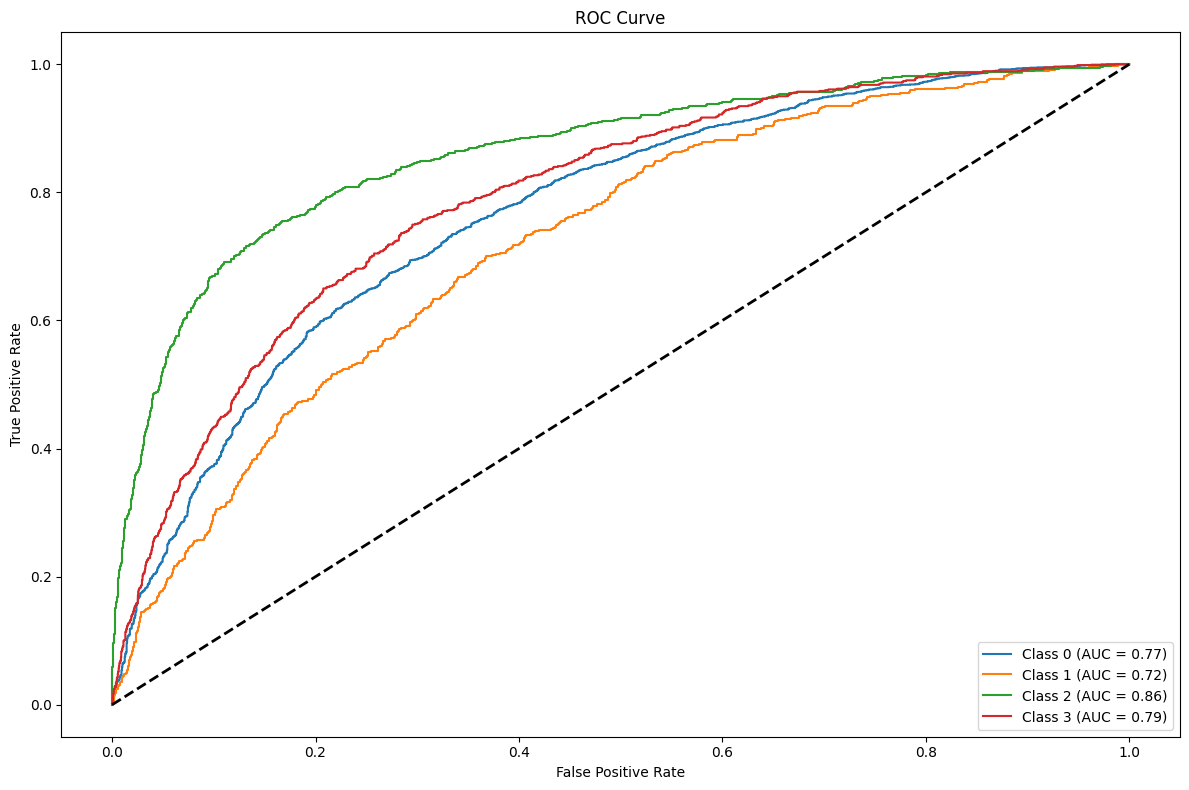

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
import datetime
def plot_roc(all_labels_binarized, all_probs, auc_scores):
    plt.figure(figsize=(12, 8))

    for i in range(len(auc_scores)):
        fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], np.array(all_probs)[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_scores[i]:.2f})")

    # Add diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    fig = plt.gcf()
    fig.tight_layout()
    plt.show()
    return fig  # Return figure for further processing if needed

roc_fig = plot_roc(all_labels_binarized,all_probs,auc_scores)


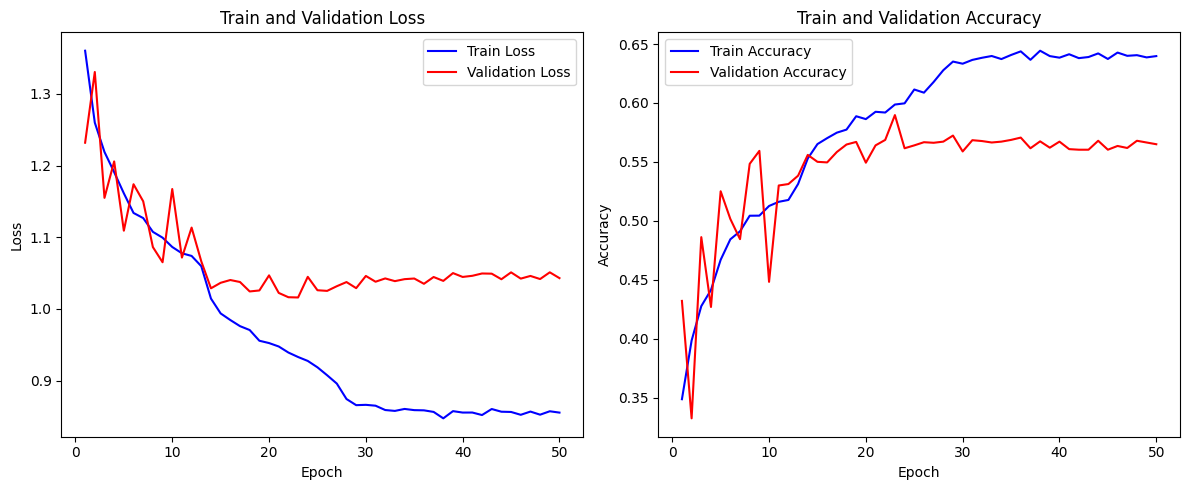

In [41]:
def plot_train_val(num_epochs, avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, avg_train_loss, 'b-', label='Train Loss')
    plt.plot(epochs, avg_val_loss, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, avg_train_acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, avg_val_acc, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()
    fig = plt.gcf()

    fig.tight_layout()
    plt.show()
    return fig
train_val_fig = plot_train_val(num_epochs, avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc)

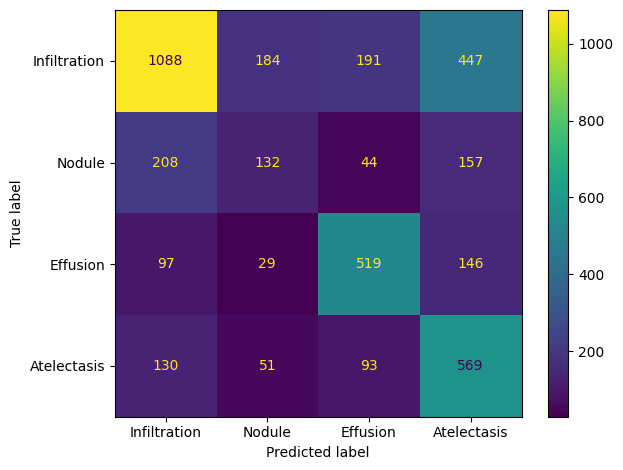

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(all_labels, all_preds, labels):
    labels = [label_to_index[label] for label in label_to_index.keys()]
    cm = Metrics.calculate_confusion_matrix(all_labels, all_preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_to_index.keys()))
    disp.plot(cmap='viridis')
    fig = plt.gcf()
    fig.tight_layout()
    plt.show()
    return fig   
cm_fig = plot_confusion_matrix(all_labels, all_preds, labels=filtered_data['Finding Labels'].unique())


In [43]:
def savefigs(cm_fig, roc_fig, train_val_fig, run_name, results_file):
    # Define file paths
    cm_plot_file = f"DNNProject/runs/confusion_matrices/confusion_matrix_{run_name}.png"
    roc_file = f"DNNProject/runs/roc_curve_{run_name}.png"
    train_val_plot_file = f"DNNProject/runs/loss_accuracy_plots/loss_accuracy_plot_{run_name}.png"

    # Save Confusion Matrix
    try:
        cm_fig.savefig(cm_plot_file, bbox_inches='tight')
        print(f"Saved Confusion Matrix: {cm_plot_file}")
    except Exception as e:
        print(f"Failed to save Confusion Matrix: {e}")
    finally:
        plt.close(cm_fig)

    # Save ROC Curve
    try:
        roc_fig.savefig(roc_file, bbox_inches='tight')
        print(f"Saved ROC Curve: {roc_file}")
    except Exception as e:
        print(f"Failed to save ROC Curve: {e}")
    finally:
        plt.close(roc_fig)

    # Save Train-Validation Plot
    try:
        train_val_fig.savefig(train_val_plot_file, bbox_inches='tight')
        print(f"Saved Train-Val Plot: {train_val_plot_file}")
    except Exception as e:
        print(f"Failed to save Train-Val Plot: {e}")
    finally:
        plt.close(train_val_fig)

    # Log files in results file
    with open(results_file, 'a') as f:
        f.write(f"\n Confusion Matrix: {cm_plot_file}")
        f.write(f"\n ROC Curve: {roc_file}")
        f.write(f"\n Train-Val Plot: {train_val_plot_file}")


In [44]:
import datetime
run_name = f"run_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S%f')}"  # Add microseconds

#metrics = str(Metrics.calculate_all(all_labels, all_preds))

# Loggfilen
results_file = 'DNNProject/runs/results_with_ROC.txt'

with open(results_file, 'a') as f:
    f.write("\n" + "="*50 + "\n")  # Separator mellom kjøringer
    f.write(f"Run: {run_name}\n")
    f.write(f"Model: {model.resnetModel}\n")
    
    f.write("Transforms:\n")
    for transform in train_transforms.transforms:
        f.write(f"  - {transform}\n")
    if 'scheduler' in globals() or 'scheduler' in locals():
        if scheduler is not None:
            scheduler_exist = True
            f.write("Scheduler:\n")
            f.write(f"  Type: {type(scheduler).__name__}\n")
            if hasattr(scheduler, 'get_last_lr'):
                f.write(f"  Initial LR: {scheduler.get_last_lr()}\n")
            if isinstance(scheduler, torch.optim.lr_scheduler.StepLR):
                f.write(f"  Step Size: {scheduler.step_size}\n")
                f.write(f"  Gamma: {scheduler.gamma}\n")
            elif isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                f.write(f"  Mode: {scheduler.mode}\n")
                f.write(f"  Patience: {scheduler.patience}\n")

    else:
        scheduler_exist = False
        f.write("Scheduler: None\n")
    f.write(f"Epochs: {num_epochs}\n")
    f.write(f"Optimizer:{optimizer.__class__.__name__} \n ")
    f.write("Hyperparameters:\n")
    if optimizer.__class__.__name__ == 'SGD':
        for i, param_group in enumerate(optimizer.param_groups):
            f.write(f"  Parameter Group {i + 1}:\n")
            f.write(f"    Learning Rate: {param_group['lr']} \n")
            f.write(f"    Weight Decay: {param_group['weight_decay']} \n")
            if 'momentum' in param_group:
                f.write(f"    Momentum: {param_group['momentum']} \n")
            else:
                f.write(f"    Momentum: Not Available\n")
    elif optimizer.__class__.__name__ == 'Adam':
        for i, param_group in enumerate(optimizer.param_groups):
            f.write(f"  Parameter Group {i + 1}:\n")
            f.write(f"    Learning Rate: {param_group['lr']} \n")
            if 'betas' in param_group:
                f.write(f"    Betas: {param_group['betas']}\n")
            else:
                f.write(f"    Betas: Not Available\n")
            f.write(f"    Weight Decay: {param_group['weight_decay']} \n")

    # Legg til tabellen
    f.write("\n Training & Validation Metrics:\n")
    f.write(table + "\n")
    
    # Legg til metrikker
    metrics = str(Metrics.calculate_all(all_labels, all_preds))
    f.write("\n Overall Metrics:\n")
    f.write(metrics + "\n")

    f.write("\n AUC-ROC Metrics:\n")
    f.write(f"Per-class AUC Scores: {auc_scores}\n")
    f.write(f"Micro-average AUC: {micro_auc:.4f}\n")
    f.write(f"Macro-average AUC: {macro_auc:.4f}\n")
    f.write(f"Plots:")
    # Lagre begge plott og oppdatere loggfilen
    savefigs(cm_fig,roc_fig,train_val_fig,run_name,results_file)


Saved Confusion Matrix: DNNProject/runs/confusion_matrices/confusion_matrix_run_20241207_124445504397.png
Saved ROC Curve: DNNProject/runs/roc_curve_run_20241207_124445504397.png
Saved Train-Val Plot: DNNProject/runs/loss_accuracy_plots/loss_accuracy_plot_run_20241207_124445504397.png


### Best Runs Data:

#### **Adam**
##### *10 Epochs ResNet34*
- Valideringsnøyaktighet: 52.44% (Beste nøyaktighet)  
- F1-Score: 42.18% (Beste F1-score)  
- AUC-ROC Macro: ~71.7%  
    - Optimizer konfigurasjon  
        - Initial LR: 0.0001  
        - Betas: (0.9, 0.999)  
        - Weight Decay: 0.001  
    - Scheduler konfigurasjon  
        - Patience: 3  
        - Mode: 'min'  

```python
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, mode='min')
```

##### *20 Epochs Resnet34*

- Accuracy: 58.11% 
- Precision: 53.97%
- Recall: 53.65%
- F1 Score: 52.71% 
- Per-class AUC: [0.776, 0.707, 0.872, 0.801]
- Macro AUC-ROC: ~78.87% 
- Micro AUC-ROC: ~81.81%

### **SGD**
#### *10 Epochs ResNet34*
- Valideringsnøyaktighet: 46.10%
- F1-Score: 39.02%
- AUC-ROC Macro: ~71.6%
- Optimizer konfigurasjon:
    - Initial LR: 0.0005
    - Momentum: 0.95
    - Weight Decay: 1e-5
- Scheduler Konfigurasjon:
    - ReduceLROnPlateau (Patience: 3, Mode: 'min')
Kode:
```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.95,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, mode='min')
```
***20 Epochs Resnet34***

- Accuracy:  0.5456548347613219 
- Precision: 0.49306798747088726 
- Recall:   0.4932766819218442 
- F1 Score:  0.4830247226456349 
- Per-class AUC: [0.747, 0.696, 0.8378,0.7635]
- Micro-average AUC: 0.7918753217905713
- Macro-average AUC: 0.7611557381045978

### **SGD**
#### *10 Epochs ResNet34*
- Valideringsnøyaktighet: 42.62%
- F1-Score: 38.98%
- AUC-ROC Macro: ~73.12% (Beste AUC per klasse)
- Optimizer Konfigurasjon:
    - Initial LR: 0.00025
    - Momentum: 0.9
    - Weight Decay: 0.001
- Scheduler Konfigurasjon:
    StepLR (Step Size: 5, Gamma: 0.5)

Kode:

```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.00025, momentum=0.9, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
```
***20 Epochs Resnet34***
- Accuracy:   0.4773561811505508 
- Precision:  0.45456504578488083
- Recall:    0.4381627089699772 
- F1 Score: 0.40042276959401246 

- Per-class AUC Scores: [0.7168815068905339, 0.6767888660327209, 0.7893465266887579, 0.7318370321909281]
- Micro-average AUC: 0.7359211013215199
- Macro-average AUC: 0.7287134829507352


### **Adam**

#### *10 Epochs ResNet34*
- Valideringsnøyaktighet: 44.65%
- F1-Score: 38.59%
- AUC-ROC Macro: ~70.5%
- Optimizer Konfigurasjon:\\
    - Initial LR: 0.0001
    - Betas: (0.9, 0.999)
    - Weight Decay: 0.0001
- Scheduler Konfigurasjon:
    - StepLR (Step Size: 10, Gamma: 0.1)

Kode

```python
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
```
***20 Epochs Resnet34***
- Accuracy: 0.5405140758873929
- Precision: 0.5142716165857042
- Recall: 0.5222382486411073
- F1 Score: 0.4971040475691635 

**AUC**

- Per-class AUC: [0.760371426852019, 0.7073985137463855, 0.8705991125111973, 0.7880282736298421]
- Micro-average: 0.7890630407392482
- Macro-average: 0.781599331684861

### ResNet34 Top 2
#### **Adam + Reduce Lr On Plateau**
##### *30 Epochs ResNet34*
- Valideringsnøyaktighet: 0.5745410036719706  
- F1-Score: 0.5174777955748133
- AUC-ROC Macro: 0.792207857351219
- AUC-ROC Micro: 0.8136401348936086
- Recall: 0.5348876131890974
- Precision: 0.5353063692042728
    - Optimizer konfigurasjon  
        - Initial LR: 0.0001  
        - Betas: (0.9, 0.999)  
        - Weight Decay: 0.001  
    - Scheduler konfigurasjon  
        - Patience: 3  
        - Mode: 'min'  
- AUC Score Class [0.7727440572907264, 0.7214322819959693, 0.8758858960512812, 0.7987691940668993]
```python
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, mode='min')
```
##### *30 Epochs ResNet50*
- Accuracy | 0.5591187270501836 
- Precision | 0.5214540247069932 
- Recall  | 0.5215156010917825 
- F1 Score | 0.5038901332264419 

- Per-class AUC Scores: [0.7652396942889812, 0.7122965372210146, 0.8660035447355918, 0.7886614592137742]
- Micro-average AUC: 0.8033145415130437
- Macro-average AUC: 0.7830503088648404

#### **SGD + Reduce Lr On Plateau**
##### *30 Epochs ResNet34*

```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.95, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, mode='min')
```
- Accuracy:   0.5383108935128519 
- Precision:  0.49311438743914593 
- Recall:    0.4991525635275238 
- F1 Score:   0.4842497996151763 
- Class AUC Scores: [0.7454445447433352, 0.6908805280748385, 0.8317962322024415, 0.7645779043295184]
- Micro-average AUC: 0.7792474183095152
- Macro-average AUC: 0.7581748023375334

##### *30 Epochs ResNet50*
- Accuracy:  0.5013463892288862 
- Precision:  0.462590141039833  
- Recall: 0.45901492285850176 
- F1 Score:  0.4385391892839646 
- Per-class AUC Scores: [0.7246350123367636, 0.6700877899383718, 0.7959251660107601, 0.7373811107622887]
- Micro-average AUC: 0.7533266915260027
- Macro-average AUC: 0.7320072697620461

Videre Testing

    20 Epochs med ResNet34:
        Tren disse fire konfigurasjonene videre i 20 epochs med ResNet34.
        Evaluer forbedringen i AUC-ROC, nøyaktighet og F1-score.

    Overfør til ResNet50:
        Bruk de beste to konfigurasjonene basert på 20 epochs-resultatene til å trene ResNet50.

    Sammenligning og Diskusjon:
        Sammenlign resultater fra både ResNet34 og ResNet50 og vurder hvilken konfigurasjon som gir mest robuste resultater for begge.